In [41]:
import numpy as np
from typing import Callable, Optional, Union, TypedDict
from scipy.signal import lfilter
import matplotlib.pyplot as plt
import plotly as pyplot
import plotly.graph_objects as graph_objects
import ipywidgets as widgets
from decimal import *

pyplot.offline.init_notebook_mode(connected=True)

In [21]:
TIMESTEP_WIDTH_MS = 0.1
T_FILTER_MS = 100
T_INJECTIONS_MS = 1000

In [22]:
def get_exponential_kernel(
    tau_ms: float, kernel_length_ms: float, dt: float = TIMESTEP_WIDTH_MS
) -> np.ndarray:
    t = np.arange(0, kernel_length_ms, dt)
    IRF_filter = np.exp(-t / tau_ms)
    IRF_filter = IRF_filter/sum(IRF_filter)
    return IRF_filter

def get_filter(kernel: np.ndarray) -> Callable[[np.ndarray], np.ndarray]:
  """Get a function that convolves the kernel with an input."""
  return lambda input_: lfilter(kernel, 1, input_, axis=-1, zi=None)

def get_sigmoid(loc: float, sensitivity: float, gain: float) -> Callable[[np.ndarray], np.ndarray]:
    def sigmoid(x):
        return gain / (1 + np.exp(-(x - loc) / sensitivity))
    return sigmoid

def my_GWN(filter_length: int, mu: float, sig: float, myseed=False):
  """
  Function that generates Gaussian white noise input

  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same
                 random number sequence

  Returns:
    I          : Gaussian white noise input
  """
  # set random seed
  # you can fix the seed of the random number generator so that the results
  # are reliable however, when you want to generate multiple realization
  # make sure that you change the seed for each new realization.
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate GWN
  # we divide here by 1000 to convert units to sec.
  I_gwn = mu +  sig * np.random.randn(filter_length) / np.sqrt(TIMESTEP_WIDTH_MS / 1000.)

  return I_gwn


In [23]:
delta_mu_pA = 0.5
sigma_pA = 1
mu_start_pA = 0

sim_parameters = list()
num_steps = 12
for i in range(0, num_steps):
    mu_pA = mu_start_pA + i * delta_mu_pA
    input_signal = my_GWN(filter_length=T_INJECTIONS_MS, mu=mu_pA, sig=sigma_pA)
    sim_parameters.append({'input': input_signal, 'mu_pA': mu_pA, 'sigma_pA': sigma_pA})


In [24]:
tau_na_ms = 3
tau_membrane_ms = 10
na_kernel = get_exponential_kernel(tau_ms=tau_na_ms, kernel_length_ms=T_FILTER_MS)
membrane_kernel = get_exponential_kernel(tau_ms=tau_membrane_ms, kernel_length_ms=T_FILTER_MS)
na_filter = get_filter(na_kernel)
membrane_filter = get_filter(membrane_kernel)

In [25]:
output_results = list()
for sim in sim_parameters:
    input_signal = sim['input']
    mu_pA = sim['mu_pA']
    V_lin = membrane_filter(input_signal)
    V_nl_prefilter = na_filter(input_signal)
    V_nl_normalized = sigmoid(V_nl_prefilter)
    V_nl = sigmoid_scale * V_nl_normalized

    output_results.append({'mu_pA': mu_pA, 'V_lin': V_lin, 'V_nl_prefilter': V_nl_prefilter, 'V_nl_normalized': V_nl_normalized, 'V_nl': V_nl})

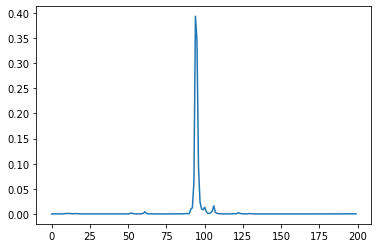

In [26]:
first_output = output_results[10]
plt.plot(first_output['V_nl_normalized'][450:650])

In [49]:
import math

mean_input_slider_min = 0
mean_input_slider_step = 0.1
mean_input_slider_max = 12
mean_inputs = np.arange(mean_input_slider_min, mean_input_slider_max, mean_input_slider_step)
out = dict()
for mean_i in mean_inputs:
    mu_pA = mu_start_pA + i * delta_mu_pA
    input_signal = my_GWN(filter_length=T_INJECTIONS_MS, mu=mean_i, sig=sigma_pA)
    V_lin = membrane_filter(input_signal)
    V_nl_prefilter = na_filter(input_signal)
    V_nl_normalized = sigmoid(V_nl_prefilter)
    V_nl = sigmoid_scale * V_nl_normalized
    out[math.floor(mean_i*1000)] = V_nl_normalized

out.keys()

dict_keys([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900])

In [56]:
layout = graph_objects.Layout(
    title='Title',
    yaxis=dict(
        title='y'
    ),
    xaxis=dict(
        title='time(ms)'
    )
)
def update_plot(mean_input, sensit):
    sigmoid_loc = 40
    sigmoid_sensit = sensit
    sigmoid_scale = 15.0
    sigmoid = get_sigmoid(loc=sigmoid_loc, sensitivity=sigmoid_sensit, gain=1)

    data = []
    input_signal = my_GWN(filter_length=T_INJECTIONS_MS, mu=mean_input, sig=sigma_pA, myseed=1)
    V_lin = membrane_filter(input_signal)
    V_nl_prefilter = na_filter(input_signal)
    V_nl_normalized = sigmoid(V_nl_prefilter)
    V_nl = sigmoid_scale * V_nl_normalized
    trace1 = graph_objects.Scatter(
        y=V_nl_normalized[:],
        mode='lines',
        line=dict(
            shape='spline'
        )
    )
    fig = graph_objects.Figure(data=[trace1], layout=layout)
    pyplot.offline.iplot(fig)

sensitivity = widgets.FloatSlider(min=0.5, max=10, value=1., description='sensitivity')
mean_input = widgets.FloatSlider(min=0, max=30, value=1., description='mean input')
widgets.interactive(update_plot, mean_input=mean_input, sensit=sensitivity)

interactive(children=(FloatSlider(value=1.0, description='mean input', max=30.0), FloatSlider(value=1.0, descr…